<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Table%20Transformer/Inference_with_Table_Transformer_(TATR)_for_parsing_tables.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load model

Next, we load a Table Transformer pre-trained for table detection. We use the "no_timm" version here to load the checkpoint with a Transformers-native backbone.

In [2]:
from ultralytics import YOLO
from PIL import Image
import numpy as np
import cv2

In [4]:

model = YOLO('yolov8n-obb.pt')  # load an official model
model = YOLO('best4.pt')
image = Image.open("2a39feb6-Document_55.jpg").convert("RGB")

results = model(image)


0: 640x480 109.4ms
Speed: 5.0ms preprocess, 109.4ms inference, 181.2ms postprocess per image at shape (1, 3, 640, 480)


In [5]:
def visualize_detection(results):
    image_array = results[0].plot(line_width=5)  # plot a BGR numpy array of predictions
    image = Image.fromarray(image_array[..., ::-1])  # RGB PIL image
    image.show()  # show image
    # image.save('yolo_results.jpg')  # save image

def crop_obb(image, points):
    # Find the minimum area rotated rectangle
    rect = cv2.minAreaRect(points)

    # Get width and height of the detected rectangle
    width = int(rect[1][0])
    height = int(rect[1][1])

    # Represent the corners of the rectangle. 
    box = cv2.boxPoints(rect)

    # Coordinate of the points in box points after the rectangle has been straightened
    dst_pts = np.array([[0, height-1],
                        [0, 0],
                        [width-1, 0],
                        [width-1, height-1]], dtype="float32")

    # The perspective transformation matrix
    M = cv2.getPerspectiveTransform(box, dst_pts)

    # Directly warp the rotated rectangle to get the straightened rectangle
    warped = cv2.warpPerspective(image, M, (width, height))

    # cv2.imwrite("crop_img.jpg", warped)

    return warped

def objects_to_crops(image, results):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """
    # Create dict to store cropped parts of image
    ind2classes = {0: 'number', 1: 'date', 2: 'sender', 3: 'table', 4: 'appendix'}
    crops = {v: None for k, v in ind2classes.items()}
    
    # Convert image to array
    image_array = np.array(image)

    # Extract predicted classes, confidednces, obbs
    cls = results[0].obb.cls.detach().cpu().numpy()
    # conf = results[0].obb.conf.detach().cpu().numpy()
    xyxyxyxy = results[0].obb.xyxyxyxy.detach().cpu().numpy()

    # Crop every part of image and add it to dict
    for i in range(len(cls)):
        cropped_image = crop_obb(image=image_array,
                                 points=xyxyxyxy[i])
        
        crops[ind2classes[cls[i]]] = cropped_image

    return crops

In [16]:
d = objects_to_crops(image=image,
                 results=results)

cropped_table = d['table']
cropped_table = Image.fromarray(cropped_table)

## Load structure recognition model

Next, we load a Table Transformer pre-trained for table structure recognition.

In [17]:
import torch
from transformers import TableTransformerForObjectDetection
device = 'cuda' if torch.cuda.is_available else 'cpu'
# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
print("")

We prepare the cropped table image for the model, and perform a forward pass.

In [18]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [19]:
pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 126, 1000])


In [20]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

Next, we get the predicted detections.

In [21]:


def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"


cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9992871880531311, 'bbox': [672.6215209960938, 7.2366180419921875, 827.1925659179688, 348.7604675292969]}, {'label': 'table spanning cell', 'score': 0.7991480231285095, 'bbox': [823.3721923828125, 6.30958890914917, 999.976806640625, 166.9930877685547]}, {'label': 'table spanning cell', 'score': 0.9838841557502747, 'bbox': [-1.5226976871490479, 6.918484687805176, 671.4364624023438, 166.80516052246094]}, {'label': 'table column', 'score': 0.9990405440330505, 'bbox': [2255.408935546875, 7.375555992126465, 2397.2353515625, 347.5893249511719]}, {'label': 'table column', 'score': 0.9994426369667053, 'bbox': [1473.483154296875, 7.379326343536377, 1620.156494140625, 347.8625793457031]}, {'label': 'table spanning cell', 'score': 0.8937975168228149, 'bbox': [673.1412353515625, 6.812313079833984, 835.5299072265625, 166.467529296875]}, {'label': 'table column header', 'score': 0.9534987211227417, 'bbox': [-0.790415346622467, 6.962296962738037, 2830.23974609375,

## Visualize cells

We can visualize all recognized cells using PIL's ImageDraw module.

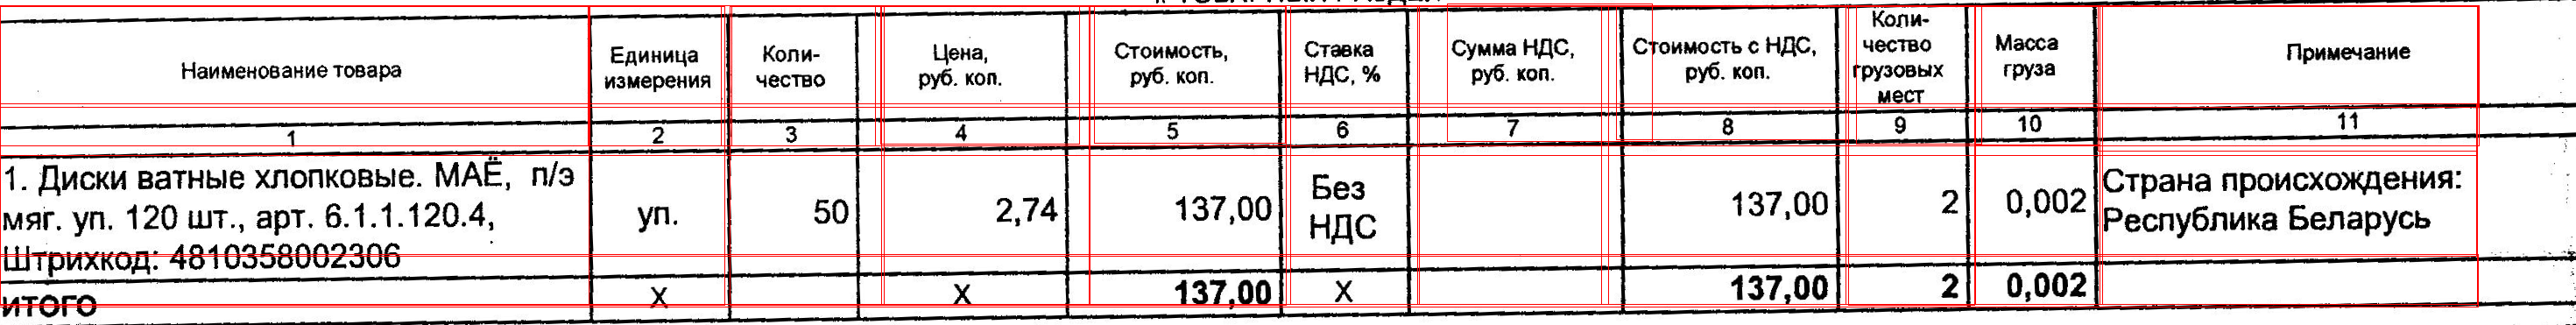

In [22]:
from PIL import ImageDraw

cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

An alternative way of plotting is to select one class to visualize, like "table row":

In [23]:
import matplotlib.pyplot as plt

def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")

    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          text = f'{cell["label"]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
          plt.axis('off')

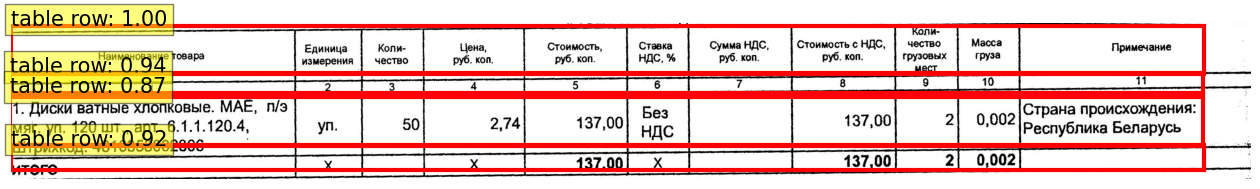

In [24]:
plot_results(cells, class_to_visualize="table row")

## Apply OCR row by row

First, we get the coordinates of the individual cells, row by row, by looking at the intersection of the table rows and columns (thanks ChatGPT!).

Next, we apply OCR on each individual cell, row-by-row.

Note that this makes some assumptions about the structure of the table: it assumes that the table has a rectangular, flat structure, containing a column header. One would need to update this for more complex table structures, potentially fine-tuning the detection and/or structure recognition model to be able to detect other layouts. Typically 50 labeled examples suffice for fine-tuning, but the more data you have, the better.

Alternatively, one could also do OCR column by column, etc.

In [25]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(cells)

In [26]:
len(cell_coordinates)

4

In [27]:
len(cell_coordinates[0]["cells"])

11

In [28]:
for row in cell_coordinates:
  print(row["cells"])

[{'column': [-0.10068636387586594, 7.1068572998046875, 672.5071411132812, 348.46087646484375], 'cell': [-0.10068636387586594, 6.703095436096191, 672.5071411132812, 122.15238189697266]}, {'column': [672.6215209960938, 7.2366180419921875, 827.1925659179688, 348.7604675292969], 'cell': [672.6215209960938, 6.703095436096191, 827.1925659179688, 122.15238189697266]}, {'column': [833.5089111328125, 7.1241278648376465, 1009.3450317382812, 348.1249084472656], 'cell': [833.5089111328125, 6.703095436096191, 1009.3450317382812, 122.15238189697266]}, {'column': [1006.3540649414062, 7.063504219055176, 1244.2327880859375, 348.2309875488281], 'cell': [1006.3540649414062, 6.703095436096191, 1244.2327880859375, 122.15238189697266]}, {'column': [1243.3797607421875, 7.043325424194336, 1468.1964111328125, 348.16015625], 'cell': [1243.3797607421875, 6.703095436096191, 1468.1964111328125, 122.15238189697266]}, {'column': [1473.483154296875, 7.379326343536377, 1620.156494140625, 347.8625793457031], 'cell': [1

In [29]:
import numpy as np
import csv
import easyocr
from tqdm.auto import tqdm

reader = easyocr.Reader(['ru']) # this needs to run only once to load the model into memory

def apply_ocr(cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
      row_text = []
      for cell in row["cells"]:
        # crop cell out of image
        cell_image = np.array(cropped_table.crop(cell["cell"]))
        # apply OCR
        result = reader.readtext(np.array(cell_image))
        if len(result) > 0:
          # print([x[1] for x in list(result)])
          text = " ".join([x[1] for x in result])
          row_text.append(text)

      if len(row_text) > max_num_columns:
          max_num_columns = len(row_text)

      data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
          row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

data = apply_ocr(cell_coordinates)

for row, row_data in data.items():
    print(row_data)

100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

Max number of columns: 11
['Наименование товара', 'Единица измерения', 'Коли- чество', 'Цена; руб. коп', 'Стоимость руб: коп', 'Ставка НДС; %', 'Сумма НДС; КОП: руб:', 'Стоимость с НДС; руб. коп:', 'Коли- чество грузовых мест', 'Масса груза', 'Примечание']
['5', '10', '', '', '', '', '', '', '', '', '']
['1. Диски ватные хлопковые: МАЁ; п/э мяг. уп. 120 шт., арт. 6.1.1.120.4, # 40405-оооэоос', 'уп:', '50', '2,74', '137,00', 'Без НДС', '137,00', '2', '0,002', 'Страна происхождения: Республика Беларусь', '']
['штрихкод: 40 10ЗЗ0.0<3 Ъ 1м', '137.00', 'Х', '137,00', '2', '0,002', '', '', '', '', '']


## Save as CSV

We end up with a CSV file containing the data.

In [31]:
import csv

with open('output.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')

    for row, row_text in data.items():
      wr.writerow(row_text)

In [32]:
import pandas as pd

df = pd.read_csv("output.csv")
df.head()

,Наименование товара,Единица измерения,Коли- чество,Цена; руб. коп,Стоимость руб: коп,Ставка НДС; %,Сумма НДС; КОП: руб:,Стоимость с НДС; руб. коп:,Коли- чество грузовых мест,Масса груза,Примечание
0,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1. Диски ватные хлопковые: МАЁ; п/э мяг. уп. 1...,уп:,50,"2,74","137,00",Без НДС,"137,00",2.0,"0,002",Страна происхождения: Республика Беларусь,NaN
2,штрихкод: 40 10ЗЗ0.0<3 Ъ 1м,137.00,Х,"137,00",2,"0,002",NaN,NaN,NaN,NaN,NaN
